<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Federated_Minst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Modified by Gibson Xue on July 25, 2021
!pip uninstall --yes tensorflow tensorboard tb-nightly
!pip install --quiet tensorflow==2.5.0
!pip install --quiet tensorflow-federated==0.19.0
!pip install --quiet nest-asyncio 
!pip install --quiet tensorboard  # or tensorboard, but not both
!pip install boto3

Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
Found existing installation: tensorboard 2.5.0
Uninstalling tensorboard-2.5.0:
  Successfully uninstalled tensorboard-2.5.0
     |████████████████████████████████| 454.3 MB 17 kB/s 
     |████████████████████████████████| 6.0 MB 28.8 MB/s 
     |████████████████████████████████| 602 kB 5.1 MB/s 
     |████████████████████████████████| 172 kB 6.3 MB/s 
     |████████████████████████████████| 192 kB 6.1 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
pymc3 3.11.2 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have t

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nest_asyncio
nest_asyncio.apply()
import boto3
print(tf.__version__)
from tensorflow_federated.python.simulation import FileCheckpointManager

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


2.5.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import collections
import functools
import os
import time
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds
import pandas as pd
np.random.seed(0)

import tarfile
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D

In [5]:
def create_keras_model():
    model = Sequential([
        # Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        # MaxPool2D(pool_size=(2, 2)),
        # Conv2D(64, (3, 3), activation='relu'),
        # MaxPool2D(pool_size=(2, 2)),
        # Flatten(),
        # Dense(512, activation='relu'),
        # Dense(10, activation='softmax')
        Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape = (28,28,1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(10, activation="softmax"),
        # Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1)),
        
        # Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'),
        # MaxPool2D(pool_size=(2,2)),
        # Dropout(0.25),
        # Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'),
        # Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'),
        # MaxPool2D(pool_size=(2,2), strides=(2,2)),
        # Dropout(0.3),
        # Flatten(),
        # Dense(512, activation = "relu", use_bias= True),
        # Dropout(0.5),
        # Dense(10, activation = "softmax")
    ])
    return model

In [96]:
experiment_name = "mnist"
method = "tff_training"
client_lr = 1e-2
server_lr = 1e-2
split = 1
NUM_ROUNDS = 30
NUM_EPOCHS = 1
BATCH_SIZE = 20
PREFETCH_BUFFER = 10

df_orig_train = pd.read_csv('/content/drive/MyDrive/mnist_train.csv')
df_orig_test = pd.read_csv('/content/drive/MyDrive/mnist_test.csv')

# X_train = df_orig_train.drop('label',axis=1).to_numpy().astype(np.int32).reshape(59999,28,28,1)
# Y_train = df_orig_train['label'].to_numpy().astype(np.int32)

x_train = df_orig_train.iloc[:,1:].to_numpy().astype(np.float32).reshape(59999,28,28,1)[:300]
y_train = df_orig_train.iloc[:,0].to_numpy().astype(np.int32).reshape(59999,1)[:300]
x_test = df_orig_test.iloc[:,1:].to_numpy().astype(np.float32).reshape(df_orig_test.shape[0],28,28,1)[:300]
y_test = df_orig_test.iloc[:,0].to_numpy().astype(np.int32).reshape(df_orig_test.shape[0],1)[:300]


# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype(np.float32).reshape(60000, 28, 28, 1)[:300]
# y_train = y_train.astype(np.int32).reshape(60000, 1)[:300]
# x_test = x_test.astype(np.float32).reshape(10000, 28, 28, 1)[:300]
# y_test = y_test.astype(np.int32).reshape(10000, 1)[:300]

In [97]:
this_dir = Path.cwd()
model_dir = this_dir / "saved_models" / experiment_name / method
output_dir = this_dir / "results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [98]:
total_image_count = len(x_train)
image_per_set = int(np.floor(total_image_count/split))

client_train_dataset = collections.OrderedDict()
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train[start:end]), ('pixels', x_train[start:end])))
    client_train_dataset[client_name] = data

train_dataset = tff.simulation.datasets.TestClientData(client_train_dataset)

sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
sample_element = next(iter(sample_dataset))

SHUFFLE_BUFFER = image_per_set


def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    print(element['pixels'])
    return collections.OrderedDict(
        x=reshape(element['pixels'], [-1, 28, 28, 1]),
        y=reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))
federated_train_data


Adding data from 0 to 300 for client : client_1
Tensor("args_1:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("args_1:0", shape=(None, 28, 28, 1), dtype=float32)
Number of client datasets: 1
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 28, 28, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


[<PrefetchDataset shapes: OrderedDict([(x, (None, 28, 28, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>]

In [99]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adam(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.SGD(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,64],float32[64],float32[1600,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)


In [101]:
def download_dir(prefix, local, bucket, client):
    """
    params:
    - prefix: pattern to match in s3
    - local: local path to folder in which to place files
    - bucket: s3 bucket with target contents
    - client: initialized s3 client object
    """
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket':bucket,
        'Prefix':prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        dest_pathname = os.path.join(local, k)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
        client.download_file(bucket, k, dest_pathname)

def untardir(path):
    for path, directories, files in os.walk(path):
        for f in files:
            if f.endswith(".tar.gz"):
                tar = tarfile.open(os.path.join(path,f), 'r:gz')
                tar.extractall()
                tar.close()        

In [ ]:
# s3_client = boto3.client('s3', endpoint_url='http://47.254.74.134:9000',
#                           aws_access_key_id='minio',
#                           aws_secret_access_key='minio123'
#                           )
# download_dir('ckpt_', '/content', '9a62fd02-0820-479f-ac8a-ed0f7fba1138', client=s3_client)

In [ ]:
# untardir('/')

In [ ]:
# files = os.listdir(path)
# state_new = iterative_process.initialize()
# os.chdir(path)
# for filePath in files:
#   if os.path.isdir(filePath):
# ckpt_manager = FileCheckpointManager(path)
# state_new = ckpt_manager.load_checkpoint(state_new,round_num=1)
# eval_model = create_keras_model()
# print(eval_model.summary())
# eval_model.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
#                     loss=losses.SparseCategoricalCrossentropy(),
#                     metrics=[metrics.SparseCategoricalAccuracy()])

In [114]:
tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

eval_model = None

In [115]:
# state.model.assign_weights_to(eval_model)
# path = '/content'
state = iterative_process.initialize()

# ckpt_manager = FileCheckpointManager(path)
eval_model = None
for round_num in range(5):
  state, tff_metrics = iterative_process.next(state, federated_train_data)
  # print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
  # newstate = ckpt_manager.load_checkpoint(newstate,round_num=round_num)
  eval_model = create_keras_model()
  eval_model.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                      loss=losses.SparseCategoricalCrossentropy(),
                      metrics=[metrics.SparseCategoricalAccuracy()])
  state.model.assign_weights_to(eval_model)
  ev_result = eval_model.evaluate(x_test, y_test, verbose=0)
  params = list(tff_metrics.items())[2][1].items()
  for k,v in params:
    if k == "sparse_categorical_accuracy":
      tff_train_acc.append(float(v))
      print("Train Acc:" + str(v))
    elif k == "loss":
      tff_train_loss.append(float(v))
      print("Train loss:" + str(v))
  tff_val_acc.append(ev_result[1])
  tff_val_loss.append(ev_result[0])
  print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")

metric_collection = {"sparse_categorical_accuracy": tff_train_acc,
                     "val_sparse_categorical_accuracy": tff_val_acc,
                     "loss": tff_train_loss,
                     "val_loss": tff_val_loss}

print(metric_collection)

if eval_model:
    eval_model.save(model_dir / (experiment_name + ".h5"))
else:
    print("training didn't started")
    exit()                    

Train Acc:0.24
Train loss:6.2085032
Eval loss : 35.64272689819336 and Eval accuracy : 0.0833333358168602
Train Acc:0.16333333
Train loss:6.176479
Eval loss : 28.885236740112305 and Eval accuracy : 0.07000000029802322
Train Acc:0.27333334
Train loss:6.785771
Eval loss : 24.433805465698242 and Eval accuracy : 0.07666666805744171
Train Acc:0.28333333
Train loss:6.9753466
Eval loss : 21.0926456451416 and Eval accuracy : 0.07000000029802322
Train Acc:0.33666667
Train loss:6.315476
Eval loss : 18.634586334228516 and Eval accuracy : 0.06333333253860474
{'sparse_categorical_accuracy': [0.23999999463558197, 0.16333332657814026, 0.273333340883255, 0.28333333134651184, 0.33666667342185974], 'val_sparse_categorical_accuracy': [0.0833333358168602, 0.07000000029802322, 0.07666666805744171, 0.07000000029802322, 0.06333333253860474], 'loss': [6.208503246307373, 6.176478862762451, 6.785770893096924, 6.975346565246582, 6.315475940704346], 'val_loss': [35.64272689819336, 28.885236740112305, 24.4338054656

[5, 10, 15, 20, 25]


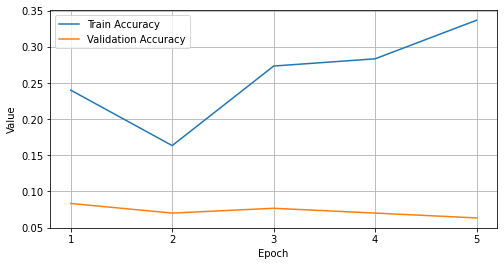

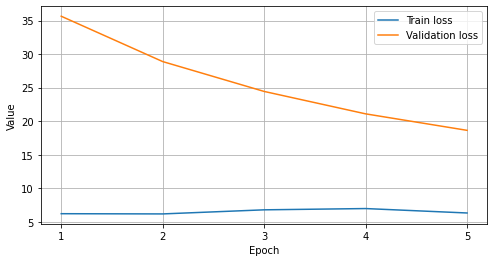

In [151]:
from matplotlib import pyplot as plt

def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)

print(list(range(1, 26))[4::5])

X = list(range(1,6))

fig = plt.figure(figsize=(8, 4))
plot_graph(X, tff_train_acc, label='Train Accuracy')
plot_graph(X, tff_val_acc, label='Validation Accuracy')
plt.legend()
plt.xticks(list(range(1,max(x)+1)),[str(i) for i in range(1,max(x)+1)])
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(8, 4))
plot_graph(X, tff_train_loss, label='Train loss')
plot_graph(X, tff_val_loss, label='Validation loss')
plt.xticks(list(range(1,max(x)+1)),[str(i) for i in range(1,max(x)+1)])
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")

In [ ]:
ckpt_manager = FileCheckpointManager(path)
ckpt_manager.save_checkpoint(state,round_num=1)


In [ ]:
!tar czvf /content/ckpt_1.tar.gz /content/ckpt_1